# Image Partition using Diffusion maps 2

Using the Nyström method discribed in the paper: [Spectral grouping using the Nystrom method](https://escholarship.org/uc/item/29z29233).

How the eigenvalues and eigenvectors are approximated is slightly different than [IP_DM_Nystrom_v1.ipynb](IP_DM_Nystrom_v1.ipynb). 

For the $n*n$ matrix $Q = \left[\begin{matrix}
A & B^T  \\
B & C \\
\end{matrix}\right] $, Nystrom extension gives
$$ Q \approx \left[\begin{matrix} A \\B \end{matrix}\right] A^{-1} \left[\begin{matrix} A & B^T \end{matrix}\right].$$

In the paper, scholar proved that by diagonalizing $S:= A+A^{-1/2} B^T B A^{-1/2}$ as $S=ULU^T$, the approximate eigenvectors of diffusion matrix are given by
$ D\left[\begin{matrix} A \\B \end{matrix}\right]A^{-1/2}UL^{-1/2}$, and the eigenvalues of diffusion matrix are equal to the eigenvalues of $S$.

This method compute only the SVD of a $sam*sam$ matrix. It is much faster than using the sparse matrix method, but slightly slower than [IP_DM_Nystrom_v1.ipynb](IP_DM_Nystrom_v1.ipynb) due to the matrix operation of using eigenvectors of $S$ to approximate eigenvectors of diffusion matrix. It can compute large images without down sampling. However, the K-means also become time-consuming when I want to cluster data in the diffusion space. 

The largest image I have calculated was images/view3.jpg , which has 2400*1500 pixels. As I set the sample number to 10 and the number of colors to 20, the elapsed time of the diffusion map is 15.2s, and the elapsed time of the K-means is 1min 48s.

### Import libraries

In [1]:
%pylab inline
import cv2
from itertools import product
from scipy.spatial.distance import cdist
from scipy import sparse
from scipy.sparse.linalg import svds
from sklearn.cluster import KMeans

Populating the interactive namespace from numpy and matplotlib


### Load image

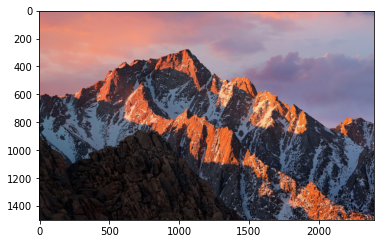

Size of figure:  1500 * 2400


In [2]:
img = cv2.imread('images/view3.jpg')
img = img[:,:,::-1]

#normalize the RGB code
img = img/255

#show image
plt.imshow(img)
plt.show()

#size
x, y, z = img.shape
n = x*y
print('Size of figure: ', x,'*',y)

### Define functions

In [3]:
#construct a diffusion map

def dm(datav):
    rand=calsam()       #randomly picked samples
    K=mk(rand)          #affinity matrix
    D, Dsmall=md(K)
    Q=mq(K, Dsmall, D)
    L, eigvec=eign(Q, D)   #eigenvalues and eigenvectors of diffusion matrix
    Y=my(L, eigvec)        #diffusion map
    
    return Y

In [4]:
#using K-means to cluster data in the diffusion space

def km(Y):
    kmeans=KMeans(clusters)
    kmeans=kmeans.fit(Y)
    labels=array(kmeans.predict(Y)).reshape(n,1)
    
    return labels

In [5]:
def calsam():
    return sort(permutation(n)[:sam])

In [6]:
def mk(rand):
    #distance matrix
    dist=vstack([cdist(datav[rand,:],datav[rand,:]), cdist(delete(datav,rand,axis=0),datav[rand,:])])
    
    #local scaling
    dist_sort=sort(dist, axis=0)    
    sigma=dist_sort[s+1,:]
    sigma[argwhere(sigma==0)]=10000
    sigmasmall=diag(1/sigma)
    
    dist_sort=sort(dist, axis=1)
    sigma=hstack([sigma,dist_sort[sam:,s+1]])
    sigma[argwhere(sigma==0)]=10000
    sigma=sparse.dia_matrix((1/sigma,0), shape=(n,n))
    
    return exp( -sigma.dot(dist).dot(sigmasmall) )    #Affinity matrix

In [7]:
def md(K):
    Dsmall=diag(1/sqrt(sum(K[:sam,:sam],axis=1)))
    D=sparse.dia_matrix((1/sqrt(sum(K,axis=1)),0), shape=(n,n))
    
    return D, Dsmall

In [8]:
def mq(K, Dsmall, D):
    return D.dot(K).dot(Dsmall)

In [9]:
def eign(Q, D):
    A=Q[:sam,:]
    B=Q[sam:,:]
    
    #A^(-1/2)
    uu, ul, uv=svd(A)
    ul=diag(ul**(-0.5))
    Asi=uu.dot(ul).dot(uv)
    
    S=A+Asi.dot(B.transpose()).dot(B).dot(Asi)

    U, L, V=svds(S, dim)

    L=diag(sqrt(L[::-1]))
    U=U[:,::-1]
    
    V=vstack([A,B]).dot(Asi).dot(U).dot(sqrt(inv(L)))
    
    eigvec=D.dot(V)
    
    return L, eigvec

In [10]:
def my(L, eigvec):
    return eigvec.dot(L)

In [11]:
def callabel(Y):
    kmeans=KMeans(clusters)
    kmeans=kmeans.fit(Y)
    labels=array(kmeans.predict(Y)).reshape(n,1)
    
    return labels

### Set parameters

In [12]:
sam=10        #number of sample to comute
s=7           #local scaling parameter
dim=3         #embedding dimension
clusters=20   #reduce image into how many colors

### Calculate the diffusion map and labeling

In [13]:
%%time

datav=img.reshape(n, z)
Y=dm(datav)

CPU times: user 9.46 s, sys: 5.54 s, total: 15 s
Wall time: 15.2 s


In [14]:
%%time

labels=km(Y)

CPU times: user 4min 3s, sys: 22.9 s, total: 4min 26s
Wall time: 1min 48s


### Display result

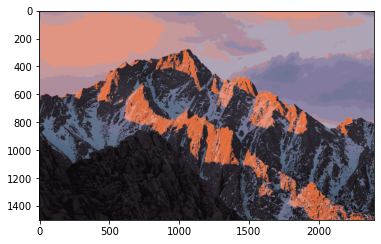

In [15]:
#calculate colors
colorrgb=[]
for i,j in product(range(clusters), range(z)):
    colorrgb.append(percentile( datav[argwhere(labels==i)[:,0],j],50 ))
    
    
#show image
imc=zeros((n,z))
for i in range(clusters): imc[argwhere(labels==i)]=colorrgb[3*i:3*i+3]
imc = imc.reshape(x,y,z)

plt.imshow(imc)
plt.show()

# print('Using', sam, 'sample points.')
# print('Using', clusters, 'colors.')

#matplotlib.image.imsave('results/IP_DM_Nystrom_v2/view6_20sam15color.jpg', imc)